In [1]:
# Test parameter estimation with a periodic kernel

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from scipy import signal
from scipy.sparse import linalg as sla
from scipy import linalg as la
from scipy import stats
from tqdm import tqdm
from scipy.optimize import minimize
import pymc3 as pm

from oceanoi import cov, oi, variogram

In [3]:
def periodic(xi, xj, params):
    eta, l, p = params
    
    d = np.abs(xi-xj)
    sin1 = np.sin(np.pi*d/p)
    sin2 = sin1*sin1
    
    l2 = l*l
    cff = -2/l2
    return eta**2*np.exp(cff*sin2)

def cosine(xi, xj, params):
    K = cov.cosine(xi, xj, params[1])
    return params[0]**2*K

4320

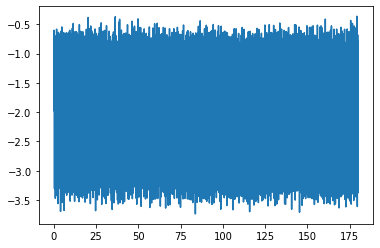

In [4]:
np.random.seed(1) # this generates the same output every time
# Generate some training data
noise = 0.1
T = 12.42*3600
covparams = (1.5, 1., T)
covfunc = periodic

#covparams = (0.5, np.sqrt(np.pi/T))
#covfunc = cosine

xd = np.arange(0,180*86400,3600)
N = xd.shape[0]
#xd = np.arange(0,dx*N,dx)
xo = xd

K = covfunc(xd[:,None], xd[:,None].T, covparams)

# L = la.cholesky(K+1e-7*np.eye(N))
# yd = L.dot(noise*np.random.normal(size=(N,)))

mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd/86400., yd,'')
N

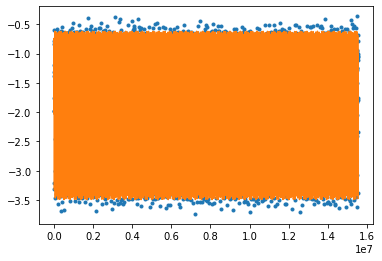

In [5]:
scale = 1

OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

In [208]:
%%time
# Minimize the log marginal likelihood
def minfunc( params, x, Z, covfunc):
    print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = oi.OptimalInterp1D(x, x, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)

    print(nll)
    return nll

method = 'L-BFGS-B'
#bounds =( (0.01,0.02), (0.05,2*dx), (0.2, 20.)) 
bounds = ((0.01,None),(0.01,None),(0.01,1),(0.01,None))
# bounds = None
covparams_ic = (0.2, 0.5, 0.1, 4.5)
options = {'eps':1e-3}

# def optlog(x):
#     print(x)
scale = 1e-4

soln = minimize(minfunc, covparams_ic,
         args=(xd*scale,  yd[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x'],  noise,  covparams[0], covparams[1], covparams[2]*scale

[0.2 0.5 0.1 4.5]
33902.77386658797
[0.201 0.5   0.1   4.5  ]
33560.216709268105
[0.2   0.501 0.1   4.5  ]
33902.316263921355
[0.2   0.5   0.101 4.5  ]
33902.12741914739
[0.2   0.5   0.1   4.501]
23798.346264614484
[0.23388222 0.50004526 0.10000009 5.49942583]
24891.129467411618
[0.23488222 0.50004526 0.10000009 5.49942583]
24680.874728229828
[0.23388222 0.50104526 0.10000009 5.49942583]
24890.665409445333
[0.23388222 0.50004526 0.10100009 5.49942583]
24889.936748446005
[0.23388222 0.50004526 0.10000009 5.50042583]
24938.67533089994
[0.21131988 0.50001512 0.10000003 4.83390318]
30554.1298360493
[0.21231988 0.50001512 0.10000003 4.83390318]
30264.225731027163
[0.21131988 0.50101512 0.10000003 4.83390318]
30553.708875603348
[0.21131988 0.50001512 0.10100003 4.83390318]
30551.810283750463
[0.21131988 0.50001512 0.10000003 4.83490318]
30574.094470106975
[0.20377701 0.50000505 0.10000001 4.61141072]
32914.17632592653
[0.20477701 0.50000505 0.10000001 4.61141072]
32589.088797148965
[0.203777

KeyboardInterrupt: 

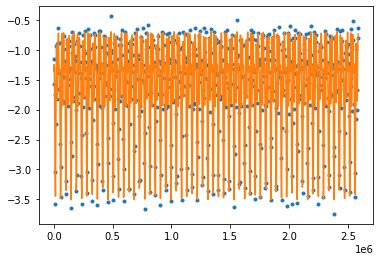

In [171]:
OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

In [23]:
scale = 1e-4

with pm.Model() as marginal_gp_model:
    # Priors
    #T = pm.Normal("T", 4.5,0.2)
    T = 12.42*3600*scale
    ℓ = pm.InverseGamma("ℓ", alpha=1,beta=1)
    #η = pm.InverseGamma("η", alpha=1,beta=1)
    σ = pm.InverseGamma("σ", alpha=3,beta=0.5)
    
    η = pm.Normal("η", 1,1)

    #η = pm.HalfCauchy("η", beta=1)
    #σ = pm.HalfCauchy("σ", beta=1)
    
    #bigno = 10
    #ℓ = pm.Uniform('ℓ', lower=0, upper=bigno)
    #η = pm.Uniform('η', lower=0, upper=bigno)
    #σ = pm.Uniform('σ', lower=0, upper=bigno)

    # Specify the covariance function.
    K = η ** 2 * pm.gp.cov.Periodic(1,T,ls=0.5*ℓ)
    
    # Full-rank method
    #gp = pm.gp.Marginal(cov_func=K)
    #y_ = gp.marginal_likelihood("y", X=xd[:,None]*scale, y=yd, noise=σ)
    
    # Sparse approx
    Xu = pm.gp.util.kmeans_inducing_points(50, xd[:,None]*scale)
    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    y_ = gp.marginal_likelihood("y", X=xd[:,None]*scale, Xu=Xu, y=yd, noise=σ)
    
    # Compute the marginal posterior
    #mp = pm.find_MAP()
    
    trace=pm.sample()

<ipython-input-23-72f0ab8a1ca4>:36: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [η, σ, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1184 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [24]:
pm.summary(trace)

/home/suntans/miniconda3/envs/sfoda/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
η  1.789  0.443   0.965    2.562      0.016    0.012     812.0     864.0   
ℓ  0.943  0.084   0.789    1.104      0.003    0.002     942.0     889.0   
σ  0.100  0.001   0.098    0.102      0.000    0.000    1072.0     938.0   

   r_hat  
η    1.0  
ℓ    1.0  
σ    1.0

In [22]:
mp, noise,  covparams[0], covparams[1], covparams[2]*scale

({'ℓ_log__': array(-0.08172986),
  'σ_log__': array(-2.30121266),
  'η': array(1.57740369),
  'ℓ': array(0.92152087),
  'σ': array(0.10013734)},
 0.1,
 1.5,
 1.0,
 4.4712000000000005)

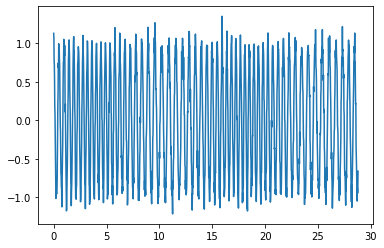

In [105]:
# Try it on a modulated sinewave
omega_A = 2*np.pi/(14.4*86400)

omega = 2*np.pi/(12.42*3600)

xd = np.arange(0,14.4*86400*2,1800)
t=xd

a0 = 1.
a_1 = 2*np.pi
#b_1 = .2
#yd = np.real((a0 + (a_1+1j*b_1)*np.exp(-1j*omega_A*t) ) * np.exp(-1j*omega*t))

# Phase modulated signal
yd = a0*np.cos(omega*t - a_1*np.cos(omega_A*t))



N = xd.shape[0]
yd += noise*np.random.normal(size=(N,))

plt.figure()
plt.plot(xd/86400.,yd)

In [106]:
# Minimize the log marginal likelihood
def minfunc( params, x, Z, covfunc):
    print(params)
    noise = params[0]
    covparams = params[1:]
    
    myOI = oi.OptimalInterp1D(x, x, noise, covfunc, covparams)
    #nll = myOI.neg_log_marginal_likelihood(x, Z, noise, covfunc, covparams)
    nll = -myOI.log_marg_likelihood(Z)

    #     print(nll)
    return nll

method = 'L-BFGS-B'
#bounds =( (0.01,0.02), (0.05,2*dx), (0.2, 20.)) 
bounds = ((0.01,None),(0.01,None),(0.01,None),(0.01,None))
# bounds = None
covparams_ic = (0.2, 0.5, 0.1, 12.42*3600*1e-3)
options = {'eps':1e-3}

# def optlog(x):
#     print(x)
scale = 1e-3

soln = minimize(minfunc, covparams_ic,
         args=(xd*scale,  yd[:,None],  covfunc),
            method=method,
            bounds=bounds,
            options=options,
         ) 
soln['x'],  noise,  covparams[0], covparams[1], covparams[2]*scale

[ 0.2    0.5    0.1   44.712]
[ 0.201  0.5    0.1   44.712]
[ 0.2    0.501  0.1   44.712]
[ 0.2    0.5    0.101 44.712]
[ 0.2    0.5    0.1   44.713]
[ 1.06612185  0.4999944   0.11176254 45.2116945 ]
[ 1.06712185  0.4999944   0.11176254 45.2116945 ]
[ 1.06612185  0.5009944   0.11176254 45.2116945 ]
[ 1.06612185  0.4999944   0.11276254 45.2116945 ]
[ 1.06612185  0.4999944   0.11176254 45.2126945 ]
[ 1.05839582  0.49949891  0.1151864  45.21153892]
[ 1.05939582  0.49949891  0.1151864  45.21153892]
[ 1.05839582  0.50049891  0.1151864  45.21153892]
[ 1.05839582  0.49949891  0.1161864  45.21153892]
[ 1.05839582  0.49949891  0.1151864  45.21253892]
[ 1.0274917   0.49751695  0.12888187 45.21091663]
[ 1.0284917   0.49751695  0.12888187 45.21091663]
[ 1.0274917   0.49851695  0.12888187 45.21091663]
[ 1.0274917   0.49751695  0.12988187 45.21091663]
[ 1.0274917   0.49751695  0.12888187 45.21191663]
[ 0.90387522  0.48958911  0.18366372 45.20842743]
[ 0.90487522  0.48958911  0.18366372 45.20842743]


(array([ 0.69588226,  0.06429981,  2.17237849, 44.71339628]),
 0.1,
 0.1,
 0.5,
 1.2)

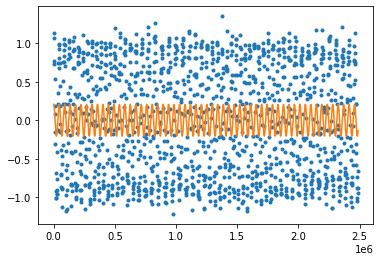

In [107]:
OI = oi.OptimalInterp1D(xd*scale,  \
                            xd*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xd, yoi,'')